In [ ]:
# import
!pip install statsmodels

import pandas as pd
import statistics

from matplotlib import pyplot

from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import mode

from sklearn.utils import resample

from pandas.plotting import autocorrelation_plot
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt

import warnings

You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.


AUTOREGRESSIVE MODEL

Part 1: Data Augmentation

In [ ]:
# Augment data
# Use window warping technique Arthur Le Guennec, Simon Malinowski, Romain Tavenard. Data Augmentation for Time Series Classification using Convolutional Neural Networks. ECML/PKDD Workshop on Advanced Analytics and
#Learning on Temporal Data, Sep 2016, Riva Del Garda, Italy. ffhalshs-01357973f


# Remove first element


# Squeeze end segment
# want 2015 to stay
# then shrink 2020 to 

Part 2: Correlations

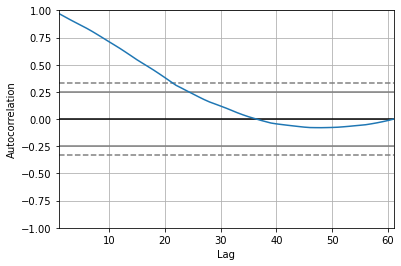

In [ ]:
full_data = pd.read_csv('data/full_data.csv')
full_data['DDate'] = full_data['DDate'].replace(['-', ' -'],'2021')

full_data['year'] = [int(i[:4]) for i in full_data['LDate']]
full_data['d_year'] = [int(i[:4]) for i in full_data['DDate']]

index_names = full_data[(full_data['year'] == 1957) | (full_data['year'] == 1958) | (full_data['year'] == 1959)].index 
  
full_data.drop(index_names, inplace = True) 

years = list(full_data['year'].unique())
years.sort()

debris_count = []

for year in years:
    debris_count.append(np.sum((full_data["year"] <= year) & (year <= full_data["d_year"])))

d = {'years': years, 'debris_count': debris_count}
dataframe = pd.DataFrame(data=d)
autocorrelation_plot(dataframe)
pyplot.show()

warnings.filterwarnings('ignore')


In [ ]:
print(dataframe)

INTERPRETATION HERE

Part 3: Validating the Model

The expected error of the model's estimations is  8302396.2193


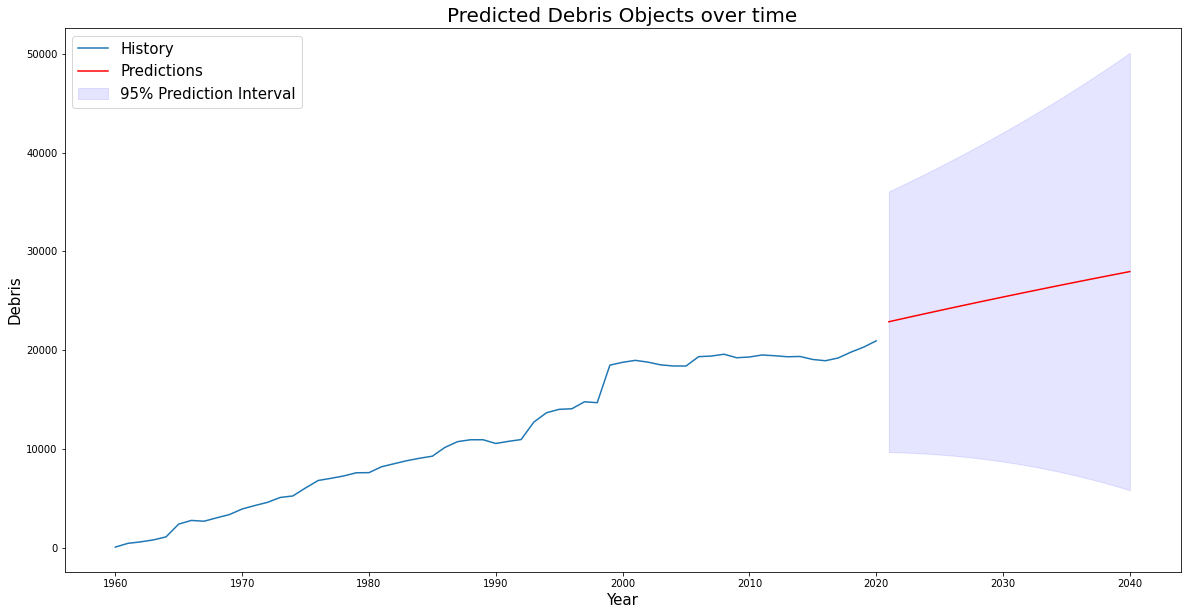

In [ ]:
# load dataset

# split dataset

def tuning(data): 
    errors = []
    bests = []
    for i in range(2, 6):
        year_end = int(i*10 + 1960)
        train_val = data[(data['years'] >= 1960) & (data['years'] < year_end)]
        test = data[(data['years'] >= year_end) & (data['years'] < (year_end+10))]    

        mse = []
        # conduct 5 fold cross validation to find optimal lag
        for j in range(1,5):
            folds = []
            for h in range(0, int((year_end-1970)/5)):
                end = int(1970 + h*5)
                train = train_val[(train_val['years'] >= 1960) & (train_val['years'] < end)]
                val = train_val[(train_val['years'] >= end) & (train_val['years'] < (end+5))]

                # fit model
                model = AutoReg(train['debris_count'], lags=j)
                model_fit = model.fit()

                # in model optimization
                predictions = model_fit.predict(start=len(train), end=len(train)+len(val)-1, dynamic=False)
                folds.append(mean_squared_error(val['debris_count'], predictions))
            mse.append(statistics.mean(folds))

        best = mse.index(min(mse)) +1 
        bests.append(best)
        model = AutoReg(train_val['debris_count'], lags=best)
        model_fit = model.fit()
        predictions = model_fit.predict(start=len(train_val), end=len(train_val)+len(test)-1, dynamic=False)
        errors.append(mean_squared_error(test['debris_count'], predictions))

    best = max(set(bests), key=bests.count) 
    expected_error = statistics.mean(errors) 

    final_model = AutoReg(data['debris_count'], lags=best)
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(data), end=len(data)+19, dynamic=False)

    return [predictions, expected_error]

base_predict = tuning(dataframe)[0].tolist()
expected_error = tuning(dataframe)[1]

# get prediction intervals
predictions = {}
values = []
keys = range(20)

for i in range(50):
    data = dataframe.copy()
    x = data['debris_count'].tolist()

    replace = []
    for i in range(1,len(x)):
        replace.append(x[i] - x[i-1])
    #data = data.sample(frac=1, replace=True)

    series = pd.Series(replace)
    series = series.sample(frac=1, replace=True).tolist()


    boots = []
    start = x[0]
    boots.append(start)


    for i in range(0, len(replace)):
        start = start + series[i]
        boots.append(start)

    data['debris_count'] = boots #data.sort_values(by=['years'], axis=0)
    returned = tuning(data)[0].tolist()
    err = tuning(data)[1]

    name = "Bootstrap " + str(i)
    values.append(returned)
    
    #predictions[name] = tuning(data)

for key in keys:
    predictions[key] = values[key]

predict_df = pd.DataFrame(data=predictions)

stds = predict_df.std(axis=1).tolist()

with_interval_plus = [j+(1.96 * stds[i]*sqrt(1.5)) for i,j in enumerate(base_predict)]
with_interval_minus = [j-(1.96 * stds[i]*sqrt(1.5)) for i,j in enumerate(base_predict)]

print("The expected error of the model's estimations is ", round(expected_error, 4))

fig, ax = pyplot.subplots(1,1, figsize=(20,10))
ax.plot(years,debris_count, label='History')
ax.plot(range(2021,2041), base_predict, color='red', label="Predictions")
ax.fill_between(range(2021,2041),with_interval_minus, with_interval_plus, color='b', alpha=.1, label='95% Prediction Interval')
ax.set_xlabel("Year", size=15)
ax.set_title("Predicted Debris Objects over time", size=20)
ax.set_ylabel("Debris", size=15)
ax.legend(loc="upper left", prop={'size':15})
pyplot.show()


Part 4: ARIMA

Test MSE: 270227.684
The best lag value is 4
The best degree of differencing is 2
The best order of moving average is 1


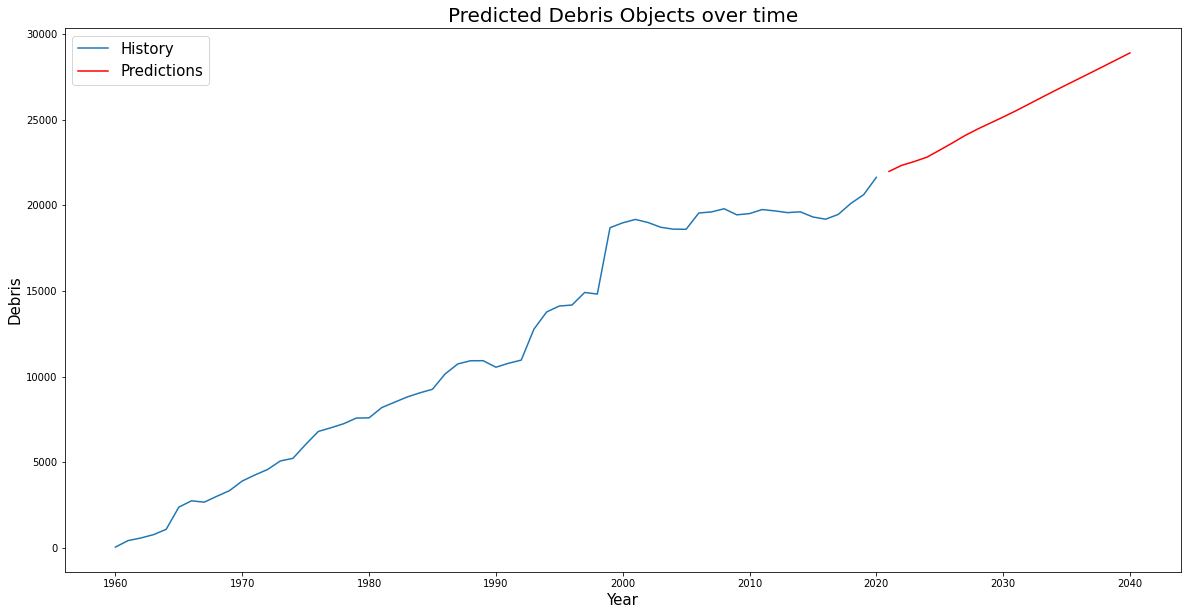

In [ ]:
# evaluate an ARIMA model using a walk-forward validation


p_potential = range(1,5)
d_potential = range(3)
q_potential = range(2)

# optimize parameters 
for p in p_potential:
	for d in d_potential:
		for q in q_potential:

			train = dataframe[(dataframe['years'] >= 1960) & (dataframe['years'] < 2005)]['debris_count'].tolist()
			test = dataframe[(dataframe['years'] >= 2005)]['debris_count'].tolist()

			history = [x for x in train]
			predictions, errors  = [], []

			for t in range(len(test)):
				model = ARIMA(history, order=(p,d,q))
				model_fit = model.fit()
				output = model_fit.forecast()
				# output.predicted_mean
				# output.se_mean
				yhat = output[0]
				predictions.append(yhat)
				obs = test[t]
				history.append(obs)
				#print('predicted=%f, expected=%f' % (yhat, obs))
			# evaluate forecasts
			mse = mean_squared_error(test, predictions)
			iteration = [p,d,q,mse]
			errors.append(iteration)

minimum = [0,errors[0][3]]
for i in errors:
	if i[3] < minimum[1]:
		minimum = [i,i[3]]

best_p = errors[minimum[0]][0]
best_d = errors[minimum[0]][1]
best_q = errors[minimum[0]][2]
			
train = dataframe['debris_count'].tolist()
#test = dataframe[(dataframe['years'] >= 2005)]['debris_count'].tolist()

history = [x for x in train]
predictions = []

for t in range(20):
	model = ARIMA(history, order=(best_p,best_d,best_q))
	model_fit = model.fit()
	output = model_fit.forecast()
				# output.predicted_mean
				# output.se_mean
	yhat = output[0]
	predictions.append(yhat)
	#obs = test[t]
	history.append(yhat)
				#print('predicted=%f, expected=%f' % (yhat, obs))
			# evaluate forecasts
#mse = mean_squared_error(test, predictions)

print('Test MSE: %.3f' % mse)
print("The best lag value is", best_p)
print("The best degree of differencing is", best_d)
print("The best order of moving average is", best_q)
# plot forecasts against actual outcomes
# pyplot.plot(test)
# pyplot.plot(predictions, color='red')
# pyplot.show()


fig, ax = pyplot.subplots(1,1, figsize=(20,10))
ax.plot(years,debris_count, label='History')
ax.plot(range(2021,2041), predictions, color='red', label="Predictions")
#ax.fill_between(range(2021,2041),with_interval_minus, with_interval_plus, color='b', alpha=.1, label='95% Prediction Interval')
ax.set_xlabel("Year", size=15)
ax.set_title("Predicted Debris Objects over time", size=20)
ax.set_ylabel("Debris", size=15)
ax.legend(loc="upper left", prop={'size':15})
pyplot.show()


# # summarize forecast and confidence intervals
# print('Expected: %.3f' % result.predicted_mean)
# print('Forecast: %.3f' % test[0])
# print('Standard Error: %.3f' % result.se_mean)
# ci = result.conf_int(0.05)
# print('95%% Interval: %.3f to %.3f' % (ci[0,0], ci[0,1]))